<a name="Inicio"></a>
# Data Analysis

#### Autor: *Ángel Pérez Lemonche*


## Descripción general

Este script utiliza las matrices de transición generadas en "Learning Paths with General *bricks*" con el fin de analizar el contenido de los datos para tomar futuras decisiones. Se puede realizar el mismo proceso utilizando **vectores de frecuencias**, normalizando por el número total de transiciones por semanas.

### Importación de librerías y declaración de funciones

In [30]:
# Librerías generales
import numpy as np
import pandas as pd
import time

import sys
sys.path.insert(0, './lib/')

import imp
import myfunclib as mf
import auxiliares as ax
import transiciones as tr
import myValFunctions as vf
import myClusteringFunctions as cf


# Librerías propias
mf = imp.reload(mf)
ax = imp.reload(ax)
#tr = imp.reload(tr)

vf = imp.reload(vf)
cf = imp.reload(cf)


pd.set_option('display.max_columns', 30)
from IPython.core.display import display, HTML, clear_output

# Librerías ML
from sklearn.cluster import KMeans

# Gráficos
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import style
#style.use("ggplot")
plt.rcParams["figure.figsize"] = [5,5]

Cargamos el fichero de entrada

In [2]:
# Diccionario semana

from datetime import datetime

### EDICION 1 ##

sem1 = datetime(2015,2,24)
sem2 = datetime(2015,3,3)
sem3 = datetime(2015,3,10)
sem4 = datetime(2015,3,17)
sem5 = datetime(2015,3,24)
sem6 = datetime(2015,3,31)
sem7 = datetime(2015,4,7)
sem8 = datetime(2015,4,14)

"""
###EDICION 2 ##

sem1 = datetime(2015,10,5)
sem2 = datetime(2015,10,12)
sem3 = datetime(2015,10,19)
sem4 = datetime(2015,10,26)
sem5 = datetime(2015,11,2)
sem6 = datetime(2015,11,9)
sem7 = datetime(2015,11,16)
sem8 = datetime(2015,11,23)
"""

SEM = {"Week1": [sem1, sem2],
       "Week2": [sem2, sem3],
       "Week3": [sem3, sem4],
       "Week4": [sem4, sem5],
       "Week5": [sem5, sem6],
       "Week6": [sem6, sem7]}

In [3]:
# Cargamos el fichero de trabajo
filename = "files/eventos_final.json"

eventsDFRaw = ax.readDataFile(filename)
eventsDFRawT = eventsDFRaw[eventsDFRaw['Usuario'] != '']
print("Tamaño:",len(eventsDFRaw))
print(eventsDFRaw.head(10))


Tamaño: 7171
                                             Eventos  Usuario
0  [{'evento': 'play_video', 'tiempo': '2015-02-2...         
1  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6139738
2  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6445710
3  [{'id_documento': '2.1. La primera interfaz de...  6594737
4  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6451715
5  [{'evento': 'load_video', 'tiempo': '2015-02-2...  4594216
6  [{'id_documento': '1.1. El entorno de desarrol...  2507090
7  [{'evento': 'load_video', 'tiempo': '2015-02-2...  5619682
8  [{'evento': 'load_video', 'tiempo': '2015-03-2...  6757226
9  [{'evento': 'load_video', 'tiempo': '2015-03-1...  6695320


In [4]:
eventsDFRaw = eventsDFRawT

In [5]:
# Filtrado por usuario: eliminamos los que hayan realizado
#  menos de 50 eventos en el curso
minEvents = 50

eventsDF = ax.dataFiltering(eventsDFRaw, minEvents);
print("Tamaño:",len(eventsDF))   
print(eventsDF.head(10))

Tamaño: 3138
                                              Eventos  Usuario
1   [{'evento': 'load_video', 'tiempo': '2015-02-2...  6139738
2   [{'evento': 'load_video', 'tiempo': '2015-02-2...  6445710
4   [{'evento': 'load_video', 'tiempo': '2015-02-2...  6451715
6   [{'id_documento': '1.1. El entorno de desarrol...  2507090
8   [{'evento': 'load_video', 'tiempo': '2015-03-2...  6757226
10  [{'id_documento': '1.1. El entorno de desarrol...  6424889
15  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6446854
16  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6407163
17  [{'evento': 'load_video', 'tiempo': '2015-02-2...   458399
22  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6539632


In [7]:
# Transiciones x semana
dicEvents = {
    'V' : ['play_video', 'seek_video'],
    'N' : ['problem_check'],
    'F' : ['edx.forum.searched', 'edx.forum.comment.created', 
           'edx.forum.response.created', 'edx.forum.thread.created'],
    'P' : ['openassessmentblock.self_assess'],
    'D' : ['textbook.pdf.chapter.navigated']
}

param = {'dicEvents': dicEvents,
         'assignationProblemCheckFile': 'IDNaturalProblemasEd1.csv',
         'ProblemCheckExceptions': ['J','X'],
         'pausaMin' : 60,
         'useFreq': True}


startTotal = time.time()
transitionsDF = tr.Transitions(eventsDF, param)
print("%.2f"%((time.time() - startTotal)/60), 'minutos.')

3.46 minutos.


In [1]:
transitionsDF.set_index('Usuario', inplace = True)

NameError: name 'transitionsDF' is not defined

In [9]:
#transitionsDF.to_csv('Transitionsdf.csv')

Reducción de dimensionalidad

In [32]:
# Selección de características

def MinMaxNorm(series):
    minim = series.min()
    maxim = series.max()
    return (series-minim)/(maxim-minim)

def TotalNorm(series):
    return series/series.sum()

def ZNorm(series):
    mean = series.mean()
    std = series.std()
    return (series-mean)/std

def featFrequency(featuresDF, info = .95, Normalize = None, Use_Rest = True, verbose = 1):
    import pandas as pd
    featDF = featuresDF.copy()
    returnDF = featuresDF.copy()

    if Normalize != None:
        featDF = featDF.apply(lambda x: Normalize(x), axis=0)
    
    suma = featDF.sum(axis=0)
    perinfo = (abs(suma)/abs(suma).sum()).sort_values(ascending=False)
    cumsum = perinfo.cumsum()

    featInfo = pd.concat([perinfo, cumsum], axis = 1)
    featInfo.columns = ['percentage', 'cumsum']
    featInfo['selection'] = (featInfo['cumsum'] < info)

    returnDF = returnDF[featInfo.index[featInfo.selection]]

    if Use_Rest:
        returnDF['Rest'] = featuresDF[featInfo.index[featInfo.selection == False]].sum(axis=1)
    
    if verbose > 0:
        print('From',len(featuresDF.columns),'to',len(returnDF.columns), 'selected features.')
        if verbose == 2:
            pd.options.display.float_format = '{:,.2f}%'.format
            toPrint = featInfo[['percentage','cumsum']].apply(lambda x: x*100)
            toPrint['selection'] = featInfo.selection
            display(toPrint)
            pd.options.display.float_format = '{:,.4f}'.format
    
    return returnDF, list(featInfo.index[featInfo.selection])

In [11]:
featuresDF, _ = featFrequency(transitionsDF, info = .95, verbose = 2)

From 48 to 17 selected features.


,percentage,cumsum,selection
E->E,14.68%,14.68%,True
V->V,13.57%,28.24%,True
A->A,11.75%,40.00%,True
D->D,10.62%,50.62%,True
V->E,10.42%,61.03%,True
E->V,8.54%,69.57%,True
V->S,8.07%,77.64%,True
S->V,7.04%,84.68%,True
E->S,1.98%,86.67%,True
D->S,1.98%,88.64%,True


### Validación

In [12]:
nClusters = 10
seed = 206
nRepetitions = 1000
computeClusterValidation = True
plt.rcParams["figure.figsize"] = [5,3]

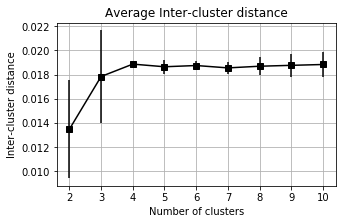

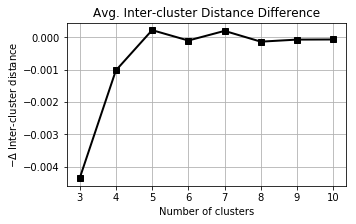

In [13]:
if computeClusterValidation:
    av, st = vf.interClusterDistKMeans(featuresDF, nClusters = nClusters, nRandomStates = nRepetitions, 
                                    seed = seed, plot = True)

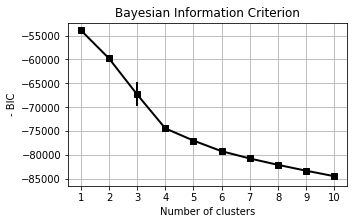

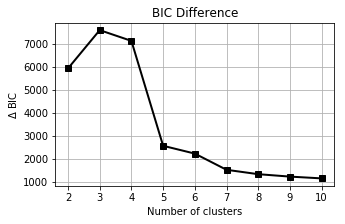

In [14]:
if computeClusterValidation:
    av, st = vf.BICCriterionKMeans(featuresDF, nClusters = nClusters, nRandomStates = nRepetitions, 
                                    seed = seed, plot = True)

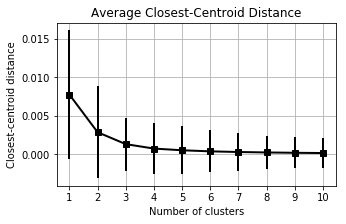

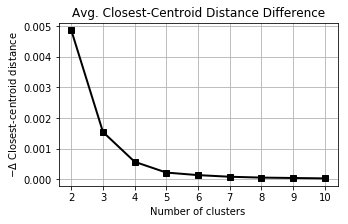

In [15]:
if computeClusterValidation:
    av, st = vf.closestCentroidDistKMeans(featuresDF, nClusters = nClusters, nInit = nRepetitions, 
                                    seed = seed, plot = True)

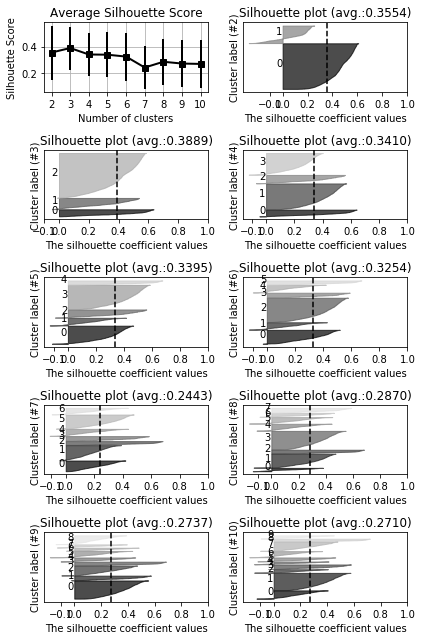

In [16]:
if computeClusterValidation:
    plt.figure(figsize=(6,9))
    av, st = vf.silhouetteKMeans(featuresDF, nClusters = nClusters, nInit = nRepetitions, 
                                    seed = seed, plot = True)

In [17]:
# EVALUATE THE PARAMETERS OF THE MODEL

from sklearn.cluster import KMeans
model = KMeans()

param_grid = {
    'n_clusters' : [6],
    'algorithm' : ['auto', 'full'],
    'init' : ['k-means++', 'random'],
    'n_init' : [20],
    'max_iter' : [200, 300],
    'random_state' : [None]
}

ParametersEvaluation = False

if ParametersEvaluation:
    nkFolds = 50
    scores, parameters, _ = vf.DeepCrossValidationClustering(featuresDF, 'KMeans', model, param_grid, kfold=nkFolds)

    print('\nEVALUATION\n')

    vf.evaluateResults(scores, parameters)

In [18]:
nInitializations = 1000
nPartitions = 0
test_size = .20

model.set_params(n_clusters = 6, algorithm = 'auto', init = 'random', max_iter = 300, n_init = 50)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=6, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Error Difference: -78.3965183298
Validation: -25.3733634813
Seed: [206, 968]


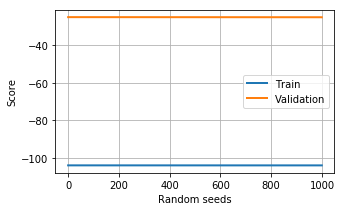

In [19]:
model = model.set_params(n_clusters = 6)

model, bestSeed, results = vf.InitializationSeed(featuresDF, model, test_size = test_size, seed = seed,
                                nRandomStates = nInitializations, CrossVal = nPartitions)
print('Seed:', bestSeed)

In [20]:
model = vf.CreatePartitionAndFitSelectedModel(featuresDF, model, test_size, bestSeed[0], bestSeed[1])
labels = model.predict(featuresDF)
centers = model.cluster_centers_

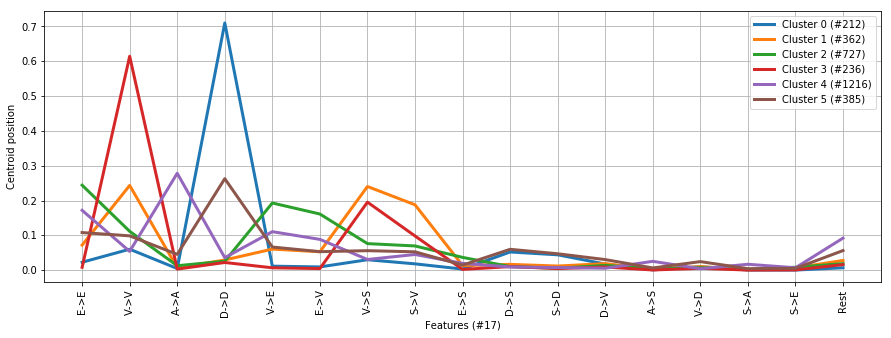

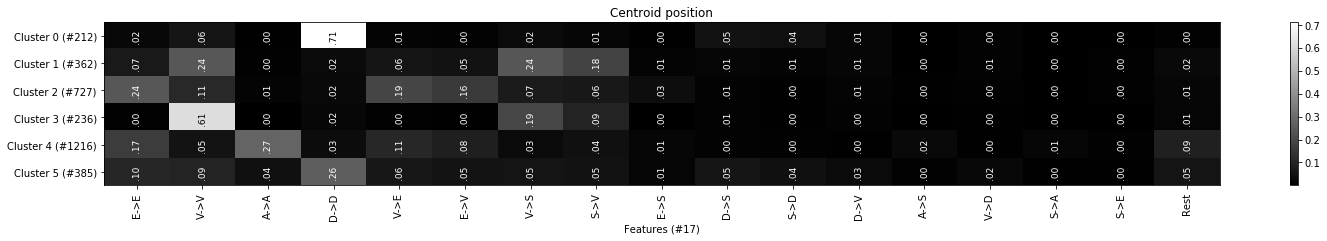

In [21]:
cf.plotCentroids(centers, labels, featuresDF.columns, sort = [], avg = False, matrix = True, textThreshold = -.01)

In [22]:
alpha = 10**-1

In [24]:
DP, DC = vf.checkClusterPositions(featuresDF, model, test_size, results, alpha)
_ =[print("%d%%"%(x[0]*100),x[1],x[2],'\n') for x in DP if (x[0]*100)>2]

DC

100% [['D->D', 'D->S', 'S->D'], ['V->V', 'V->S', 'S->V'], ['E->E', 'V->E', 'E->V', 'E->S'], ['V->V', 'V->S', 'S->V'], ['E->E', 'A->A', 'A->S', 'S->A', 'Rest'], ['D->D', 'D->S', 'S->D', 'D->V', 'V->D']] [206, 968] 



[("['D->D', 'D->S', 'S->D']", 0.2),
 ("['V->V', 'V->S', 'S->V']", 0.2),
 ("['E->E', 'V->E', 'E->V', 'E->S']", 0.2),
 ("['E->E', 'A->A', 'A->S', 'S->A', 'Rest']", 0.2),
 ("['D->D', 'D->S', 'S->D', 'D->V', 'V->D']", 0.2)]

Plotting 6 clusters


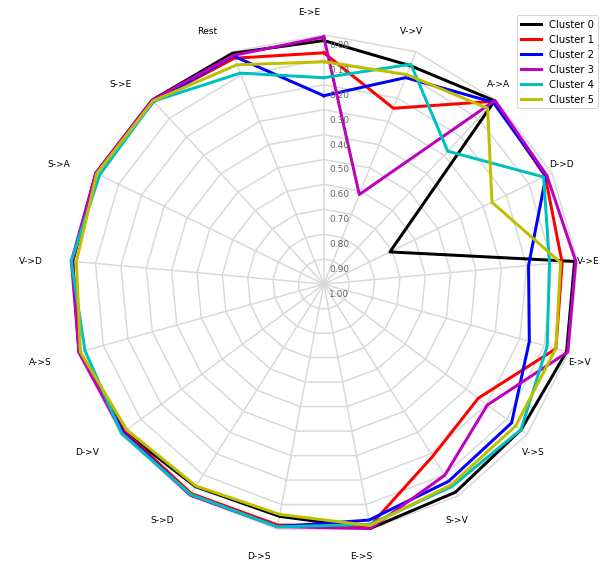

In [27]:
plt.rcParams["figure.figsize"] = [10,10]
cf.plotVectors(centers, dimensionNames = list(featuresDF.columns), colors = [], Nlevels = 10,
                logF = False, inv = True, minim = 0, verbose = True)

In [35]:
pd.options.display.float_format = '{:,.4f}'.format

mf.showTable(pd.DataFrame(list(featuresDF.index),columns = ['users']), pd.DataFrame(labels, columns = ['labels']))

,N. Usuarios,Nota (mean),Nota (std),T. Carga (mean),T. Carga (std),T. Fin (mean),T. Fin (std),N. Eventos (mean),N. Eventos (std)
0,212.0000,0.0373,0.1469,18.0236,12.0984,23.4151,13.0289,41.2972,30.0104
1,362.0000,0.1669,0.7994,13.9945,10.5861,20.7072,12.8726,21.9448,25.8928
2,727.0000,0.1569,0.2884,9.2765,7.0085,13.8721,9.9264,27.6933,18.2152
3,236.0000,0.0538,0.3180,17.6059,13.8188,20.1864,14.8341,10.4746,12.3118
4,"1,216.0000",3.9501,3.4992,15.8832,6.1274,28.4630,10.0897,130.5518,60.7158
5,385.0000,0.8122,2.0305,12.0935,8.7033,20.6649,12.6047,64.2935,67.5415
